In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_data_dir = "preprocessed/train"

In [4]:
valid_data_dir =  "preprocessed/valid"

In [5]:
test_data_dir = "preprocessed/test"

In [6]:
# Set image size for resizing
img_width, img_height = 224, 224

batch_size = 64

# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                             target_size=(img_width, img_height),
                                             batch_size=batch_size,
                                             class_mode='binary') 

Found 30250 images belonging to 2 classes.


In [8]:
valid_generator = validation_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 3319 images belonging to 2 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(img_width, img_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

Found 6300 images belonging to 2 classes.


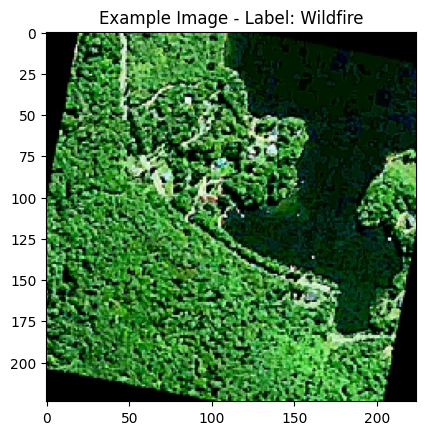

In [10]:
example_batch = next(train_generator)

# Extract the first image and label from the batch
example_image = example_batch[0][0]
example_label = example_batch[1][0]

if example_label == 1.0:
    label = "Wildfire"
else:
    label = "No Wildfire"

# Display the example image and label
plt.imshow(example_image)
plt.title(f"Example Image - Label: {label}")
plt.show()

In [22]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # number of classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [24]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 3, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [25]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),  # Adjust based on data size
    epochs=3,  # Adjust number of epochs
    validation_data=valid_generator,
    validation_steps=len(valid_generator),  # Adjust based on data size
    callbacks=[early_stopping, checkpoint]  # Add callbacks as needed
)

Epoch 1/3


C:\Users\pl23927\AppData\Local\Temp\ipykernel_14744\228440194.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


473/473 [==============================] - 2863s 6s/step - loss: 0.1568 - accuracy: 0.9402 - val_loss: 0.0952 - val_accuracy: 0.9644
Epoch 2/3
473/473 [==============================] - 2982s 6s/step - loss: 0.1153 - accuracy: 0.9567 - val_loss: 0.0863 - val_accuracy: 0.9669
Epoch 3/3
473/473 [==============================] - 2654s 6s/step - loss: 0.1028 - accuracy: 0.9609 - val_loss: 0.0973 - val_accuracy: 0.9650


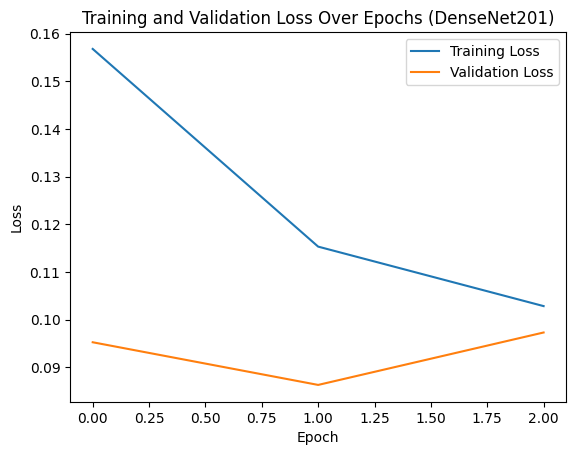

In [31]:
# Extract loss values from the history
loss = history.history['loss']
val_loss = history.history['val_loss']  # Extract validation loss values

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')  # Plot validation loss
plt.title('Training and Validation Loss Over Epochs (DenseNet201)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
# Loading best weights
model.load_weights('best_model_densenet201.h5')

In [28]:
preds = model.predict(test_generator)  
test_loss, test_acc = model.evaluate(test_generator) 

99/99 [==============================] - 456s 5s/step - loss: 0.0871 - accuracy: 0.9703


In [29]:
print('\nTest Loss: ', test_loss)
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')


Test Loss:  0.0871315449476242

Test Accuracy:  97.0 %


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


# Predict on the test generator
y_pred = model.predict_generator(test_generator)

# Get true labels from the test generator
y_true = []
num_batches = len(test_generator)
for i in range(num_batches):
    _, labels = test_generator[i]  # Assuming your test generator yields (data, labels) tuples
    y_true.extend(labels)

y_true = np.array(y_true)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision
precision = precision_score(y_true, y_pred_binary)

# Calculate recall
recall = recall_score(y_true, y_pred_binary)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


C:\Users\pl23927\AppData\Local\Temp\ipykernel_14744\2928304725.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


Precision: 0.5525007312079555
Recall: 0.542816091954023
F1 Score: 0.5476155964632555


In [33]:
print('Precision: ', np.round(precision * 100), '%')

Precision:  55.0 %


In [34]:
print('Recall: ', np.round(recall * 100), '%')

Recall:  54.0 %


In [35]:
print('F1 Score: ', np.round(f1 * 100), '%')

F1 Score:  55.0 %


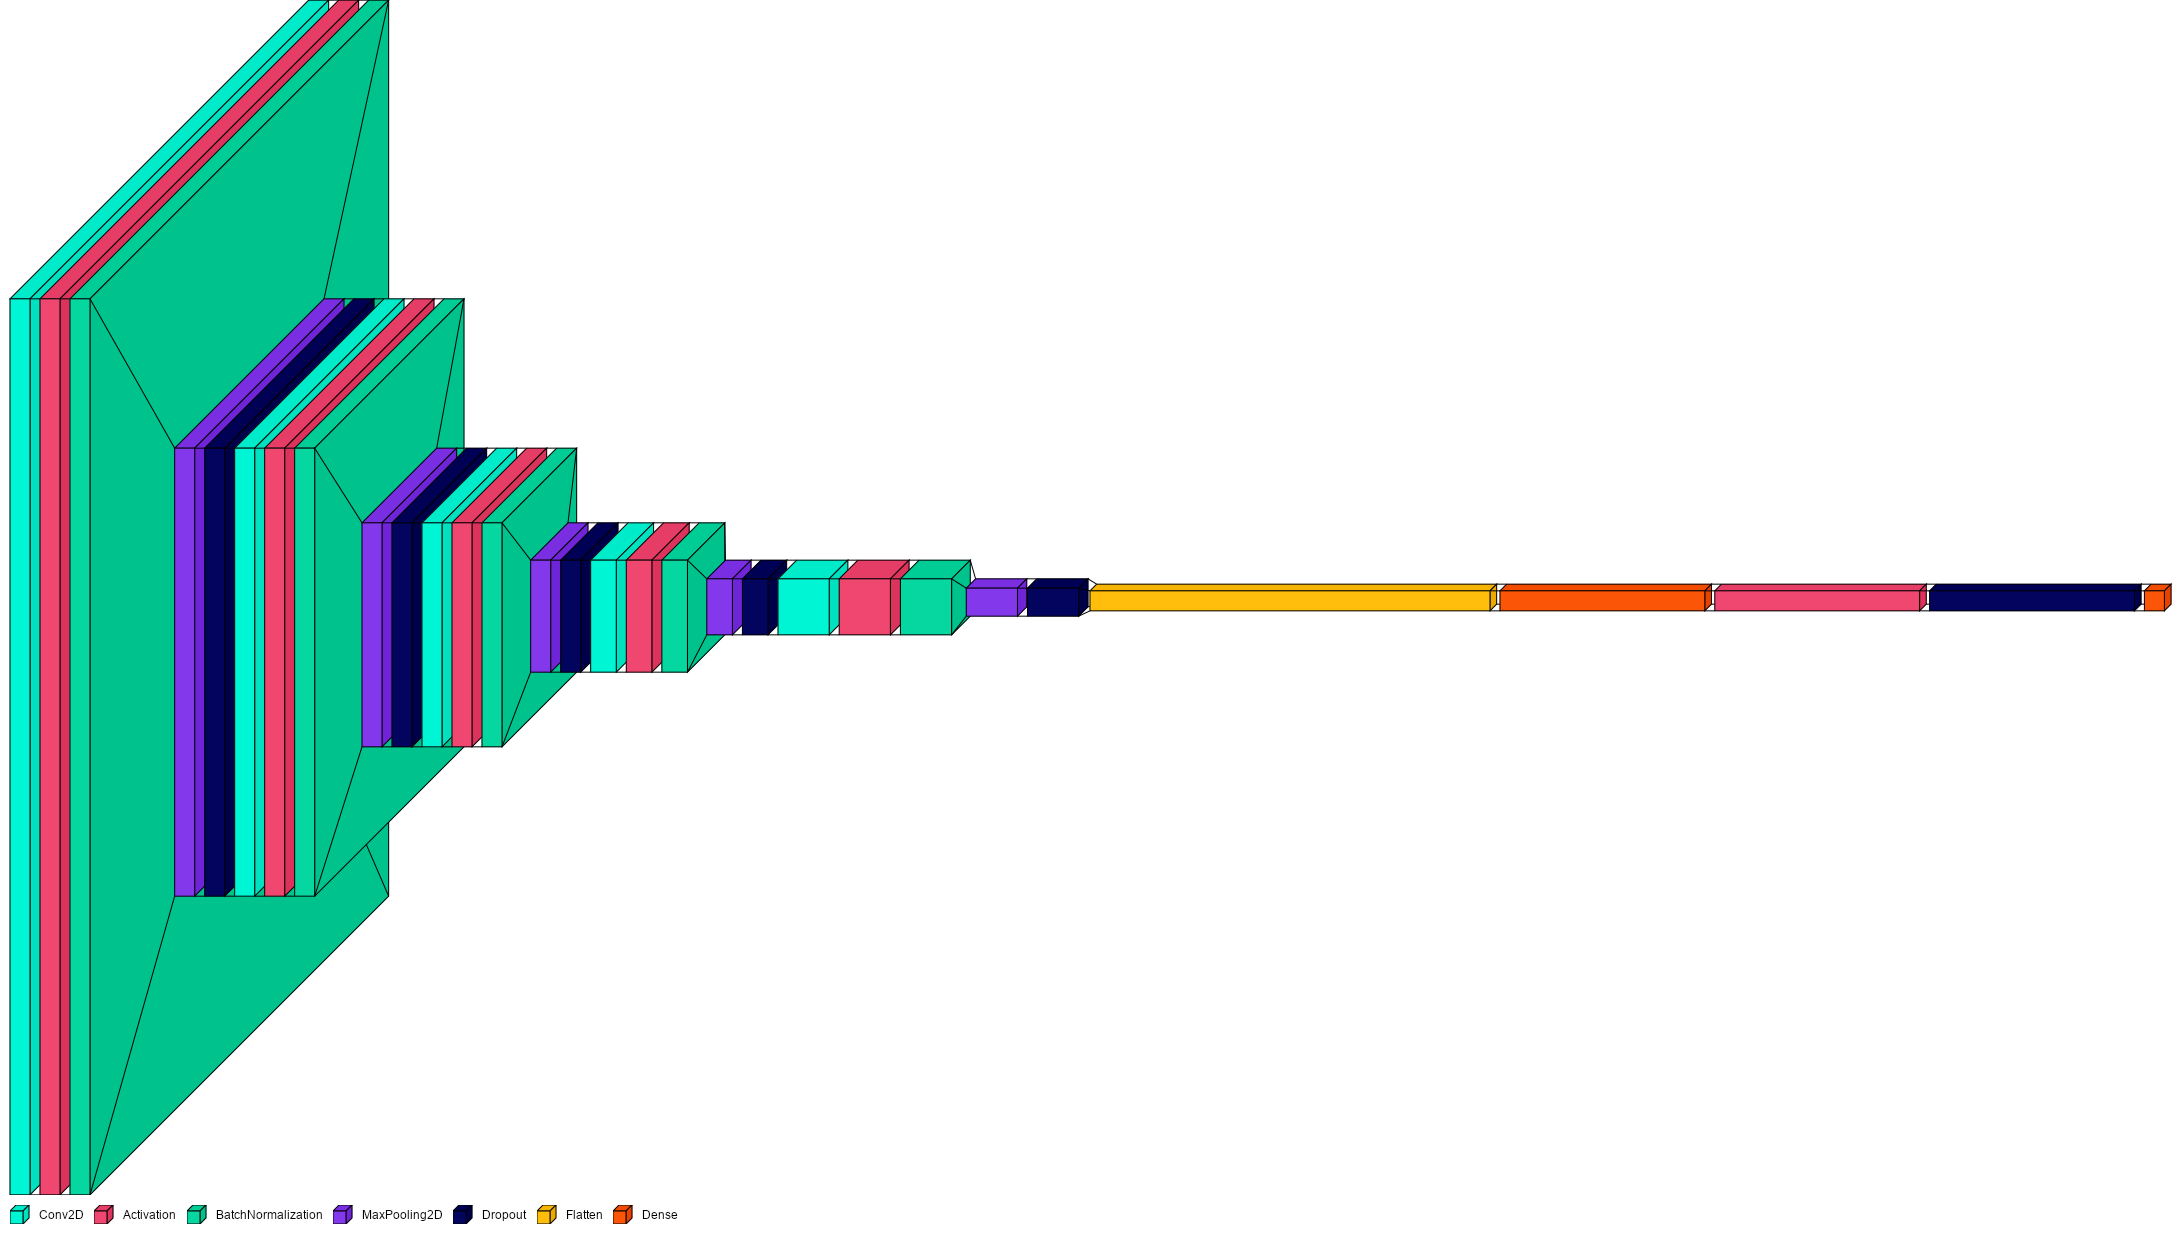

In [ ]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map)